<h1>Lending Club Case Study</h1>

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

<h2>1. Data Cleaning and Manipulation</h2>

In [17]:
# Read the Excel file into a DataFrame
raw_data = pd.read_csv("loan.csv")
raw_data.shape

(39717, 111)

<b>Drop Columns that has all null</b>

In [18]:
columns = raw_data.isna().sum()
nullcolumns = columns[columns == 39717].index.tolist()
#print("List of Null Columns ", nullcolumns)
print("Number of Null columns dropped", len(nullcolumns))
raw_data = raw_data.drop(nullcolumns, axis=1)
raw_data.shape

Number of Null columns dropped 54


(39717, 57)

<b>Drop Columns that has same value across all rows</b>

In [19]:
dupcolumns = [column for column in raw_data.columns if raw_data[column].nunique()==1]
#print("List of Duplicate Columns ", dupcolumns)
print("Number of duplicate columns dropped", len(dupcolumns))
raw_data = raw_data.drop(dupcolumns, axis=1)
raw_data.shape

Number of duplicate columns dropped 9


(39717, 48)

<b>Remove other columns which is not relevant for the analysis</b>

In [20]:
raw_data = raw_data.drop(["id", "member_id","funded_amnt", "funded_amnt_inv", "emp_title", "url", "desc", "title", "next_pymnt_d", "last_pymnt_d"], axis=1)
raw_data.shape

(39717, 38)

<b>Impute Values</b>

In [21]:
# Fill all 'NA' values
raw_data['mths_since_last_delinq'] = raw_data['mths_since_last_delinq'].fillna(0)
raw_data['emp_length'] = raw_data['emp_length'].fillna(0)
raw_data['pub_rec_bankruptcies'] = raw_data['pub_rec_bankruptcies'].fillna(0)
raw_data['mths_since_last_record'] = raw_data['mths_since_last_record'].fillna(0)
raw_data['revol_util'] = raw_data['revol_util'].fillna(0)

# Replace values in few columns and change type from object to int/float64
raw_data['term'] = raw_data['term'].str.replace(' months', '')
raw_data['term'] = raw_data['term'].astype('int64')
raw_data['int_rate'] = raw_data['int_rate'].str.replace('%', '')
raw_data['int_rate'] = raw_data['int_rate'].astype('float64')
raw_data['revol_util'] = raw_data['revol_util'].str.replace('%', '')
raw_data['revol_util'] = raw_data['revol_util'].astype('float64')
raw_data['emp_length'] = raw_data['emp_length'].str.replace('10\+ years', '10')
raw_data['emp_length'] = raw_data['emp_length'].str.replace(' years', '')
raw_data['emp_length'] = raw_data['emp_length'].str.replace(' year', '')
raw_data['emp_length'] = raw_data['emp_length'].str.replace('< 1', '0.5')
raw_data['emp_length'] = raw_data['emp_length'].astype('float64')
raw_data['emp_length'] = raw_data['emp_length'].fillna(0)
raw_data = raw_data.rename(columns={'term': 'term_in_months', 'revol_util': 'revol_util_in_percent', 'emp_length':'years_of_exp'})
raw_data.isna().sum()

loan_amnt                   0
term_in_months              0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
years_of_exp                0
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
zip_code                    0
addr_state                  0
dti                         0
delinq_2yrs                 0
earliest_cr_line            0
inq_last_6mths              0
mths_since_last_delinq      0
mths_since_last_record      0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util_in_percent      50
total_acc                   0
out_prncp                   0
out_prncp_inv               0
total_pymnt                 0
total_pymnt_inv             0
total_rec_prncp             0
total_rec_int               0
total_rec_late_fee          0
recoveries

In [22]:
lc_analysis_data = raw_data[raw_data.loan_status != "Current"]
lc_analysis_data.shape

(38577, 38)

<h2>2. Data analysis</h2>

<h3>Univariate Analysis</h3>

In [30]:
def remove_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data >= lower_bound) & (data <= upper_bound)]

<h4> Charged Off applications increase for larger loan amounts. E.g. Loan amount more than 30000 dollors
have 28.6% defaulters (Amongst Charged off + fully paid)</h4>

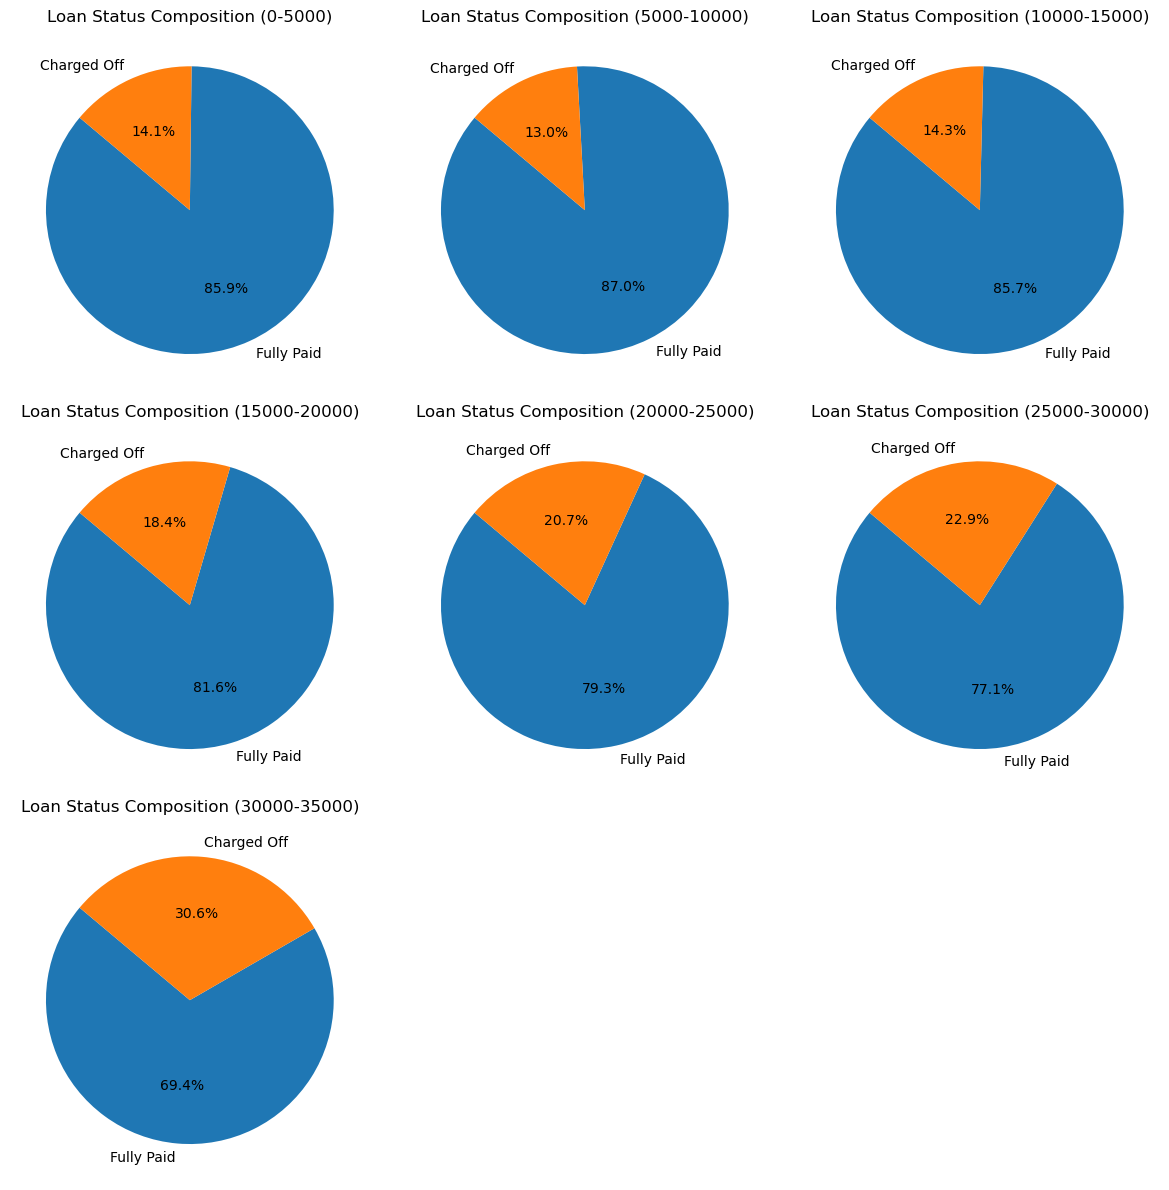

In [32]:
# Create bins for 'loan_amnt' column
bin_width = 5000
bins = range(0, int(lc_analysis_data['loan_amnt'].max()) + bin_width, bin_width)

# Group the data by 'loan_amnt' using the defined bins
grouped = lc_analysis_data.groupby(pd.cut(lc_analysis_data['loan_amnt'], bins=bins))
num_bins = len(grouped)

# Calculate the number of rows and columns for the grid
num_rows = (num_bins - 1) // 3 + 1
num_cols = min(num_bins, 3)

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

# Flatten the axes array for easier indexing
axes = axes.ravel()

# Iterate through each bin and create a pie chart for 'loan_status' composition
for i, (group_name, group_data) in enumerate(grouped):
    # Calculate the composition of 'loan_status' within the current bin
    status_composition = group_data['loan_status'].value_counts(normalize=True)
    
    # Create a pie chart
    axes[i].pie(status_composition, labels=status_composition.index, autopct='%1.1f%%', startangle=140)
    
    # Set title
    axes[i].set_title(f'Loan Status Composition ({group_name.left}-{group_name.right})')

# Remove any remaining empty subplots
for i in range(num_bins, num_rows * num_cols):
    fig.delaxes(axes[i])

# Adjust spacing between subplots
plt.tight_layout()

# Display the grid of pie charts
plt.show()

<h4> Group F and G have the hightest Charged off applicants. To be specific F5 sub group have 50% charged off application </h4>

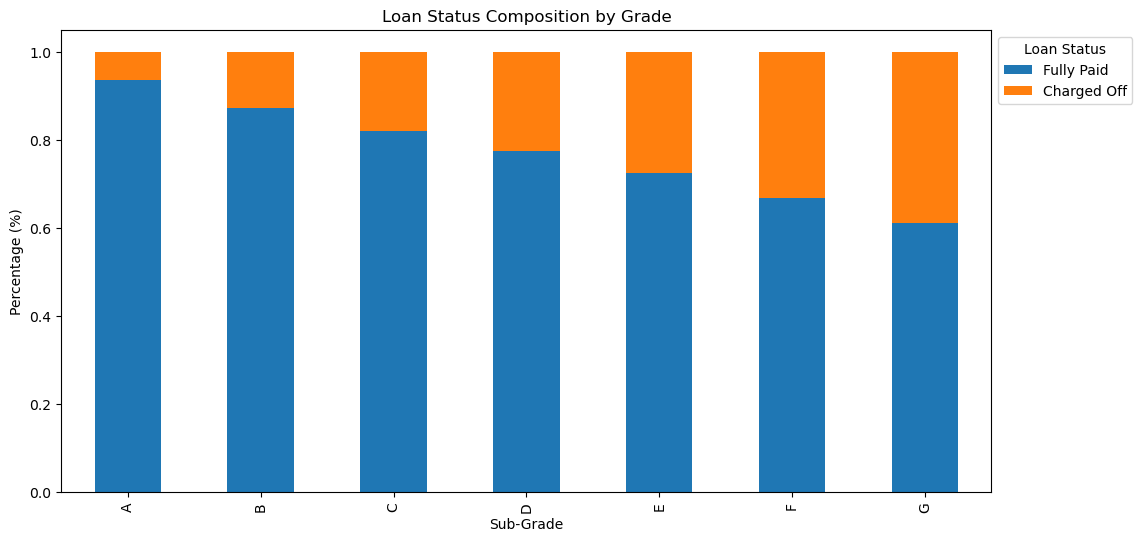

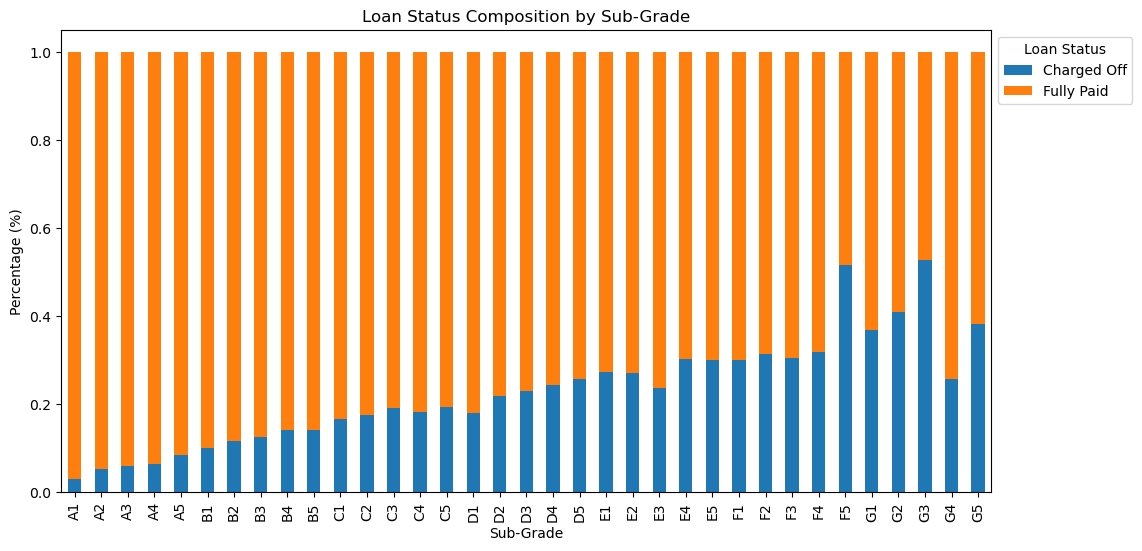

In [33]:
grouped = lc_analysis_data.groupby('grade')

# Calculate the composition of 'loan_status' for each grade
subgroup_compositions = {}
for group_name, group_data in grouped:
    status_composition = group_data['loan_status'].value_counts(normalize=True)
    subgroup_compositions[group_name] = status_composition

# Create a DataFrame from the compositions
composition_df = pd.DataFrame(subgroup_compositions).T.fillna(0)

# Plotting a bar chart for the composition
composition_df.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Loan Status Composition by Grade')
plt.xlabel('Sub-Grade')
plt.ylabel('Percentage (%)')
plt.legend(title='Loan Status', bbox_to_anchor=(1, 1))

# Show the plot
plt.show()
grouped = lc_analysis_data.groupby('sub_grade')

# Calculate the composition of 'loan_status' for each subgroup
subgroup_compositions = {}
for group_name, group_data in grouped:
    status_composition = group_data['loan_status'].value_counts(normalize=True)
    subgroup_compositions[group_name] = status_composition

# Create a DataFrame from the compositions
composition_df = pd.DataFrame(subgroup_compositions).T.fillna(0)

# Plotting a bar chart for the composition
composition_df.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Loan Status Composition by Sub-Grade')
plt.xlabel('Sub-Grade')
plt.ylabel('Percentage (%)')
plt.legend(title='Loan Status', bbox_to_anchor=(1, 1))

# Show the plot
plt.show()

<h4> Small Business loan type are the highest to Charge off and marriage loan type are safest. May be consider to revise interest rate of small business</h4>

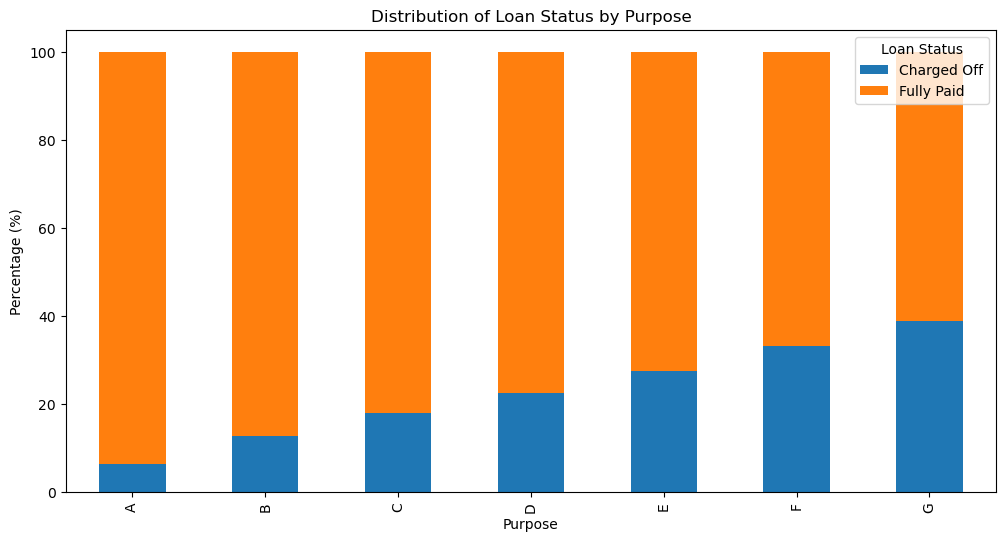

In [35]:
grouped = lc_analysis_data.groupby(['purpose', 'loan_status']).size().unstack(fill_value=0)

# Calculate the total count of each 'purpose' group
total_counts = grouped.sum(axis=1)

# Calculate the percentage distribution for each 'purpose' group
percentage_distribution = (grouped.T / total_counts * 100).T

percentage_distribution.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Distribution of Loan Status by Purpose')
plt.xlabel('Purpose')
plt.ylabel('Percentage (%)')
plt.legend(title='Loan Status')

# Show the plot
plt.show()

<h4> Loans with less interest rate i.e. less than 11.26% have higher probablity of getting fully payed back  </h4>

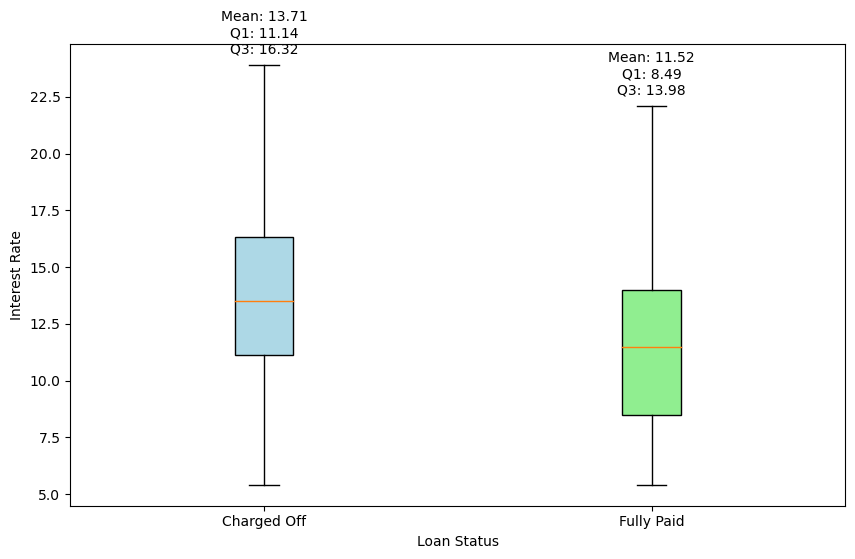

In [37]:
# Group the data by 'loan_status'
grouped = lc_analysis_data.groupby('loan_status')

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create a list to store cleaned data for each 'loan_status' group
cleaned_data_to_plot = []

# Create a list to store statistical values for each group
statistical_values = []

# Iterate through each 'loan_status' group, remove outliers, and store cleaned data and statistics
for _, group in grouped:
    cleaned_data = remove_outliers(group['int_rate'])
    cleaned_data_to_plot.append(cleaned_data)
    
    mean_value = cleaned_data.mean()
    Q1 = cleaned_data.quantile(0.25)
    Q3 = cleaned_data.quantile(0.75)
    
    stats_text = f'Mean: {mean_value:.2f}\nQ1: {Q1:.2f}\nQ3: {Q3:.2f}'
    statistical_values.append(stats_text)

# Create a box plot for the cleaned data on the same plot
box_plot = ax.boxplot(cleaned_data_to_plot, vert=True, patch_artist=True, labels=grouped.groups.keys())

# Add labels and title
ax.set_xlabel('Loan Status')
ax.set_ylabel('Interest Rate')

# Set colors for the box plots
colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)

# Add statistical values as text to the plot
for i, stats in enumerate(statistical_values):
    ax.text(i + 1, max(cleaned_data_to_plot[i]) + 0.5, stats, horizontalalignment='center', fontsize=10)

# Display the plot
plt.show()

<h4>  Derogaroty Clients and those with Public record of bankruptcies have higher probablity to default.</h4>

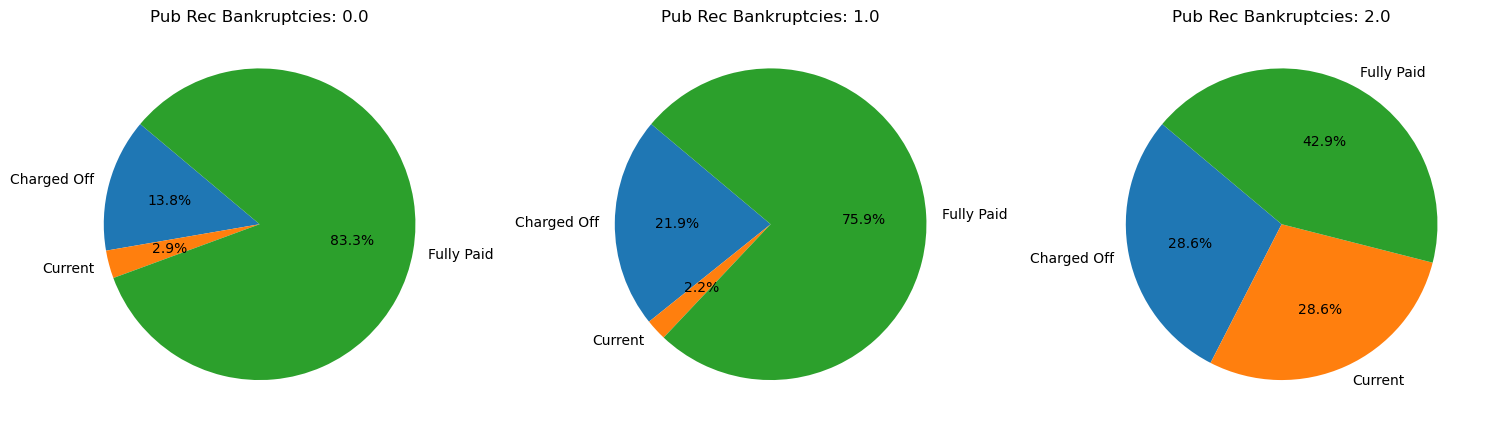

In [39]:
grouped = raw_data.groupby(['pub_rec_bankruptcies', 'loan_status']).size().unstack(fill_value=0)

# Create a figure with three subplots in one row
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Loop through each 'pub_rec_bankruptcies' group and create a pie chart
for i, (pub_rec, distribution) in enumerate(grouped.iterrows()):
    ax = axes[i]
    
    # Create a pie chart for the distribution of 'loan_status'
    ax.pie(distribution, labels=distribution.index, autopct='%1.1f%%', startangle=140)
    
    # Set title
    ax.set_title(f'Pub Rec Bankruptcies: {pub_rec}')
    
# Adjust spacing between subplots
plt.tight_layout()

# Display the subplots
plt.show()

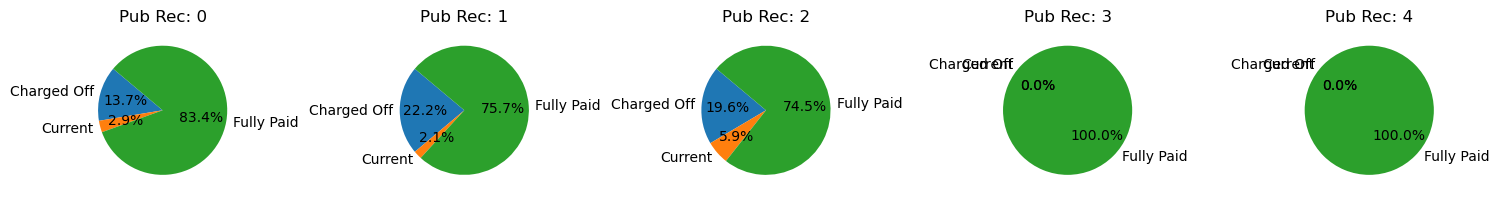

In [40]:
grouped = raw_data.groupby(['pub_rec', 'loan_status']).size().unstack(fill_value=0)

# Create a figure with three subplots in one row
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

# Loop through each 'pub_rec_bankruptcies' group and create a pie chart
for i, (pub_rec, distribution) in enumerate(grouped.iterrows()):
    ax = axes[i]
    
    # Create a pie chart for the distribution of 'loan_status'
    ax.pie(distribution, labels=distribution.index, autopct='%1.1f%%', startangle=140)
    
    # Set title
    ax.set_title(f'Pub Rec: {pub_rec}')
    
# Adjust spacing between subplots
plt.tight_layout()

# Display the subplots
plt.show()

<h3>Bivariate Analysis</h3>

In [75]:
lc_analysis_data_default = lc_analysis_data[lc_analysis_data.loan_status == "Charged Off"]
lc_analysis_data_default.columns

Index(['loan_amnt', 'term_in_months', 'int_rate', 'installment', 'grade',
       'sub_grade', 'years_of_exp', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util_in_percent',
       'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'last_credit_pull_d', 'pub_rec_bankruptcies'],
      dtype='object')

<Axes: xlabel='grade', ylabel='count'>

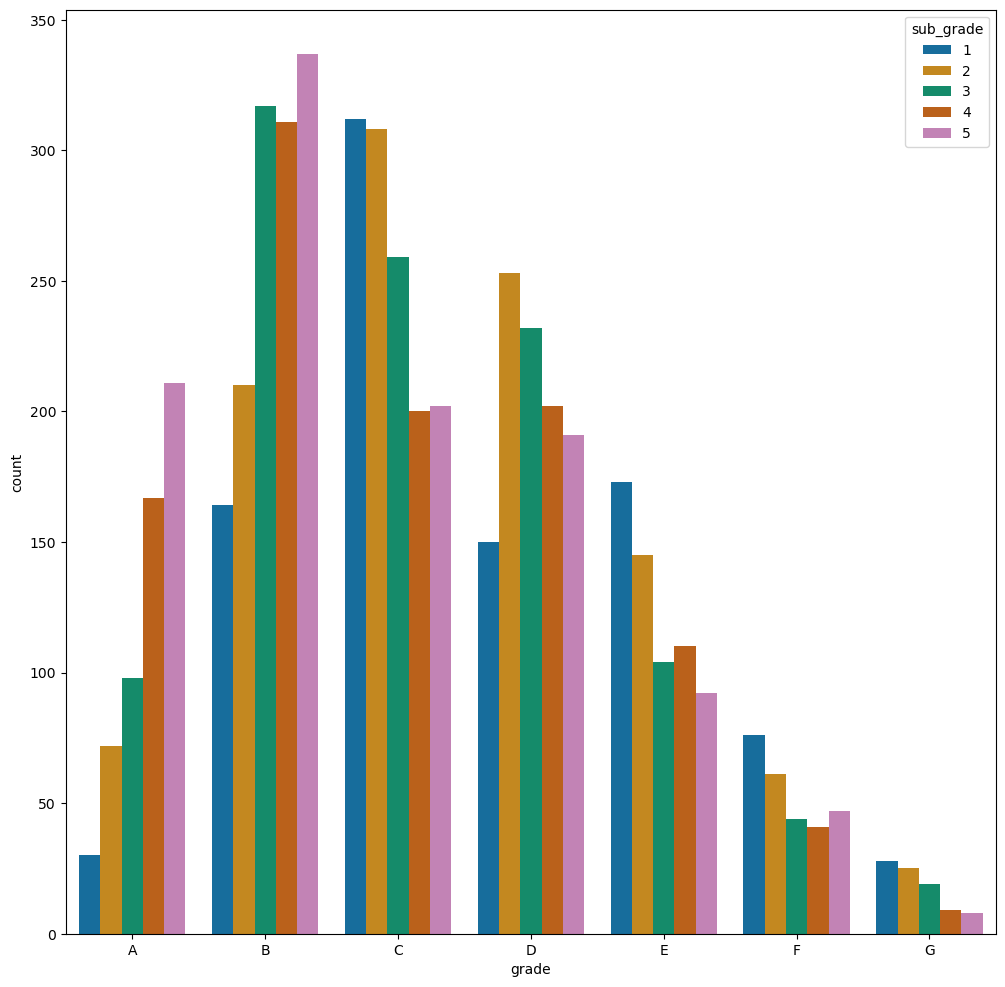

In [65]:
fig, ax = plt.subplots(figsize=(12,12))
sns.set_palette('colorblind')
sns.countplot(x = 'grade', order = ['A', 'B', 'C', 'D', 'E', 'F', 'G'] , hue = 'sub_grade',
              data = lc_analysis_data_default)

<Axes: xlabel='purpose', ylabel='grade'>

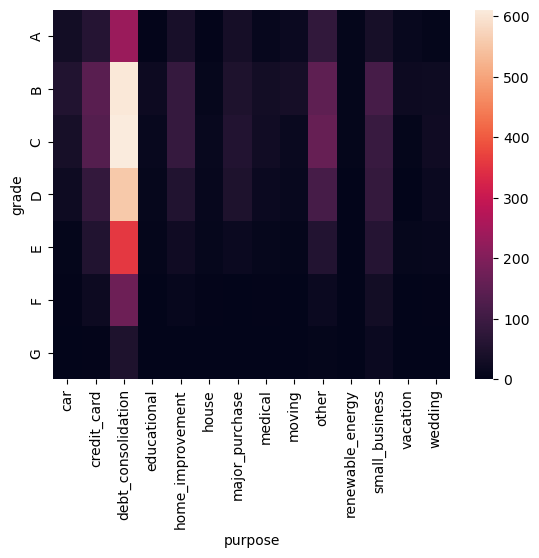

In [94]:
sns.heatmap(pd.crosstab(lc_analysis_data_default.grade, lc_analysis_data_default.purpose))


<Axes: xlabel='loan_amnt', ylabel='int_rate'>

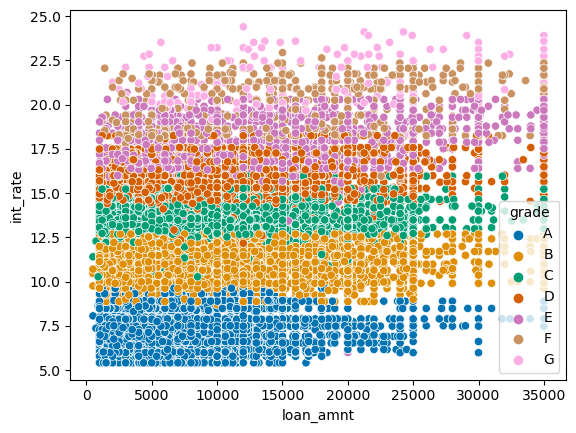

In [92]:
sns.scatterplot(x="loan_amnt",
                    y="int_rate",
                    hue="grade",
                    hue_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G'],
                    data=lc_analysis_data_default[])